In [1]:
import time
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datasetPlt as dataset
import cv2
from sklearn.metrics import confusion_matrix
from datetime import timedelta
%matplotlib inline
correct_sum = 0

ModuleNotFoundError: No module named 'google'

In [6]:
# Convolutional Layer 1.
filter_size1 = 5
num_filters1 = 16

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 32

# Convolutional Layer 4.
filter_size3 = 4
num_filters3 = 8

# Fully-connected layer.
fc_size = 128            

num_channels = 3
img_size = 64

img_size_flat = img_size * img_size * num_channels

img_shape = ( img_size, img_size)


classes = ['Apple_Apple_scab',
           'Apple_Black_rot','Apple_healthy','Apple_Cedar_apple_rust','Blueberry_healthy','Cherry_healthy',
           'Cherry_Powdery_mildew','Corn_Cercospora_leaf_spot Gray_leaf_spot','Corn_Common_rust','Corn_Northern_Leaf_Blight',
           'Corn_healthy','Grape_Black_rot','Grape_Esca_(Black_Measles)','Grape_healthy','Grape_Leaf_blight',
           'Orange_Haunglongbing','Peach_Bacterial_spot','Pepper_bell_Bacterial_spot','Pepper_bell_healthy',
           'Peach_healthy','Potato_Early_blight','Potato_healthy','Potato_Late_blight','Raspberry_healthy',
           'Soybean_healthy','Squash_Powdery_mildew','Strawberry_healthy','Strawberry_Leaf_scorch',
           'Tomato_Bacterial_spot','Tomato_Tomato_Yellow_Leaf_Curl_Virus','Tomato_Tomato_mosaic_virus','Tomato_Target_Spot',
           'Tomato_Early_blight','Tomato_Spider_mites_Two-spotted_spider_mite','Tomato_Septoria_leaf_spot',
           'Tomato_Leaf_Mold','Tomato_Late_blight','Tomato_healthy']

num_classes = len(classes)

batch_size = 32


validation_size = .16


early_stopping = None

train_path = '/plnt_villa/train'
test_path = '/plnt_villa/test'
print("done")

done


In [7]:
data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)
test_images, test_ids = dataset.read_test_set(test_path, img_size)

#cv2.imshow('img', test_images[0])
#cv2.waitKey(500)

38
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Reading training images
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
7589
Reading test images


In [8]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
- Training-set:		6375
- Test-set:		0
- Validation-set:	1214


In [9]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
  
    plt.show()

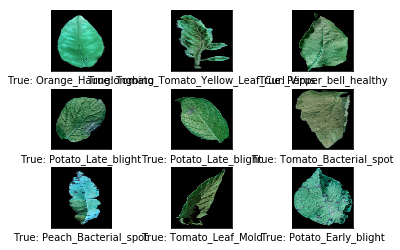

In [10]:


images, cls_true  = data.train.images, data.train.cls

plot_images(images=images, cls_true=cls_true)

In [11]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [12]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [13]:
def new_conv_layer(input,              
                   num_input_channels, 
                   filter_size,        
                   num_filters,        
                   use_pooling=True):

   
    shape = [filter_size, filter_size, num_input_channels, num_filters]

   
    weights = new_weights(shape=shape)

   
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases
    
    

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)
    
    
    


    return layer, weights

In [14]:
def flatten_layer(layer): 

    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [15]:
def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs,    
                 use_relu=True,
                 drop_out = True): 

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases
    if drop_out:
        layer = tf.nn.dropout(layer , 0.60)

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [16]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


In [17]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 32, 32, 16) dtype=float32>

In [18]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 16, 16, 32) dtype=float32>

In [19]:
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=False)
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 16, 16, 8) dtype=float32>

In [20]:
layer_flat, num_features = flatten_layer(layer_conv3)
layer_flat
num_features

2048

In [21]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         drop_out = True)
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 128) dtype=float32>

In [22]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False,
                         drop_out = False)
layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 38) dtype=float32>

In [23]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)
y_pred
y_pred_cls

<tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>

In [24]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,labels=y_true)
cost = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-5).minimize(cost)

In [26]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [27]:
session = tf.Session()
#session run
session.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [28]:
train_batch_size = batch_size

In [29]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss, train_loss):
 

    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} - T_A: {1:>6.1%}, V_A: {2:>6.1%}, Validation Loss: {3:.3f}, train_loss : {4:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss, train_loss))
    return epoch + 1, acc, val_acc, val_loss

In [30]:

total_iterations = 0


def optimize(num_iterations):

    
    global total_iterations
    # time-usage
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations, total_iterations + num_iterations):

        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

    
        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

    
        #print( "{}  \100 ".format(i) ,end='\r')
        session.run(optimizer, feed_dict=feed_dict_train)

        if i%100 == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            train_loss = session.run(cost, feed_dict=feed_dict_train)
            
            epoch = total_iterations
          
            epoch, ta, va, vl = print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss, train_loss)
            
            
            

            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break
            total_iterations += 1

    end_time = time.time()

    time_dif = end_time - start_time

    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [31]:
def plot_example_errors(cls_pred, correct):

    
    incorrect = (correct == False)
    
    
    images = data.valid.images[incorrect]
    
    cls_pred = cls_pred[incorrect]

    cls_true = data.valid.cls[incorrect]
    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [32]:
def plot_confusion_matrix(cls_pred):

    cls_true = data.valid.cls
    
    cm = confusion_matrix(y_true=cls_true,y_pred=cls_pred)

    plt.matshow(cm)

    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')


    
    plt.show()

In [33]:

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    
    num_test = len(data.valid.images)

    correct_sum = 0
    
    cls_pred = np.zeros(shape=num_test, dtype=np.int)


    i = 0

    while i < num_test:
        j = min(i + batch_size, num_test)
        
        images = data.valid.images[i:j, :].reshape(j-i, img_size_flat)
        
       # print(j-i)
    
        labels = data.valid.labels[i:j, :]

        feed_dict = {x: images,
                     y_true: labels}
        
        
        
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j
        
    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    
    correct = (cls_true == cls_pred)

  
    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [34]:
print_test_accuracy()
optimize(num_iterations=1)

Accuracy on Test-Set: 2.7% (33 / 1214)
Epoch 1 - T_A:   0.0%, V_A:   0.0%, Validation Loss: 3.666, train_loss : 3.645
Time elapsed: 0:00:01


In [35]:
print ( "start")
optimize(num_iterations=20000)  

saver = tf.train.Saver()
save_path = saver.save(session, 'C:/Users/Abhi/Desktop/project/plnt_villa/model0.ckpt')
print("Model saved in file: %s" % save_path)

start
Epoch 2 - T_A:   0.0%, V_A:   6.2%, Validation Loss: 3.618, train_loss : 3.655
Epoch 3 - T_A:   0.0%, V_A:   0.0%, Validation Loss: 3.665, train_loss : 3.615
Epoch 4 - T_A:   3.1%, V_A:   3.1%, Validation Loss: 3.649, train_loss : 3.659
Epoch 5 - T_A:   0.0%, V_A:   0.0%, Validation Loss: 3.613, train_loss : 3.629
Epoch 6 - T_A:   3.1%, V_A:   0.0%, Validation Loss: 3.619, train_loss : 3.629
Epoch 7 - T_A:   6.2%, V_A:   3.1%, Validation Loss: 3.614, train_loss : 3.619
Epoch 8 - T_A:   3.1%, V_A:   3.1%, Validation Loss: 3.619, train_loss : 3.628
Epoch 9 - T_A:  15.6%, V_A:   3.1%, Validation Loss: 3.630, train_loss : 3.622
Epoch 10 - T_A:   6.2%, V_A:   3.1%, Validation Loss: 3.562, train_loss : 3.595
Epoch 11 - T_A:   0.0%, V_A:   3.1%, Validation Loss: 3.587, train_loss : 3.628
Epoch 12 - T_A:   3.1%, V_A:   9.4%, Validation Loss: 3.578, train_loss : 3.583
Epoch 13 - T_A:   9.4%, V_A:   9.4%, Validation Loss: 3.524, train_loss : 3.604
Epoch 14 - T_A:   6.2%, V_A:  12.5%, Valid

Epoch 105 - T_A:  18.8%, V_A:  25.0%, Validation Loss: 2.485, train_loss : 2.519
Epoch 106 - T_A:  31.2%, V_A:  28.1%, Validation Loss: 2.379, train_loss : 2.111
Epoch 107 - T_A:  18.8%, V_A:  21.9%, Validation Loss: 2.876, train_loss : 2.719
Epoch 108 - T_A:  18.8%, V_A:  28.1%, Validation Loss: 2.373, train_loss : 2.374
Epoch 109 - T_A:  43.8%, V_A:  37.5%, Validation Loss: 2.605, train_loss : 2.294
Epoch 110 - T_A:  46.9%, V_A:  31.2%, Validation Loss: 2.007, train_loss : 2.251
Epoch 111 - T_A:  21.9%, V_A:  28.1%, Validation Loss: 2.462, train_loss : 2.784
Epoch 112 - T_A:  28.1%, V_A:  15.6%, Validation Loss: 2.745, train_loss : 2.517
Epoch 113 - T_A:  28.1%, V_A:  15.6%, Validation Loss: 2.557, train_loss : 2.633
Epoch 114 - T_A:  18.8%, V_A:  21.9%, Validation Loss: 2.517, train_loss : 2.663
Epoch 115 - T_A:  31.2%, V_A:  25.0%, Validation Loss: 2.227, train_loss : 2.253
Epoch 116 - T_A:  34.4%, V_A:  34.4%, Validation Loss: 2.648, train_loss : 2.602
Epoch 117 - T_A:  18.8%, V_A

In [36]:
print ( "start")
optimize(num_iterations=9000) 
saver = tf.train.Saver()
save_path = saver.save(session, 'C:/Users/Abhi/Desktop/project/plnt_villa/model2.ckpt')
print("Model saved in file: %s" % save_path)

start
Epoch 202 - T_A:  21.9%, V_A:  28.1%, Validation Loss: 2.277, train_loss : 2.559
Epoch 203 - T_A:  43.8%, V_A:  25.0%, Validation Loss: 2.495, train_loss : 1.960
Epoch 204 - T_A:  28.1%, V_A:  46.9%, Validation Loss: 1.832, train_loss : 2.402
Epoch 205 - T_A:  53.1%, V_A:  21.9%, Validation Loss: 2.254, train_loss : 2.105
Epoch 206 - T_A:  25.0%, V_A:  43.8%, Validation Loss: 1.955, train_loss : 2.482
Epoch 207 - T_A:  37.5%, V_A:  31.2%, Validation Loss: 2.474, train_loss : 2.107
Epoch 208 - T_A:  31.2%, V_A:  40.6%, Validation Loss: 1.952, train_loss : 1.998
Epoch 209 - T_A:  46.9%, V_A:  37.5%, Validation Loss: 2.265, train_loss : 2.186
Epoch 210 - T_A:  25.0%, V_A:  50.0%, Validation Loss: 2.090, train_loss : 2.486
Epoch 211 - T_A:  46.9%, V_A:  28.1%, Validation Loss: 2.280, train_loss : 1.486
Epoch 212 - T_A:  28.1%, V_A:  37.5%, Validation Loss: 2.227, train_loss : 2.228
Epoch 213 - T_A:  43.8%, V_A:  28.1%, Validation Loss: 2.489, train_loss : 2.160
Epoch 214 - T_A:  25.0

In [39]:
print ( "start")
optimize(num_iterations=30000) 
saver = tf.train.Saver()
save_path = saver.save(session, 'C:/Users/Abhi/Desktop/project/plnt_villa/model3.ckpt')
print("Model saved in file: %s" % save_path)

start
Epoch 304 - T_A:  40.6%, V_A:  43.8%, Validation Loss: 1.741, train_loss : 1.900
Epoch 305 - T_A:  46.9%, V_A:  34.4%, Validation Loss: 2.146, train_loss : 1.481
Epoch 306 - T_A:  50.0%, V_A:  28.1%, Validation Loss: 2.404, train_loss : 1.683
Epoch 307 - T_A:  62.5%, V_A:  43.8%, Validation Loss: 2.241, train_loss : 1.531
Epoch 308 - T_A:  46.9%, V_A:  34.4%, Validation Loss: 2.034, train_loss : 1.906
Epoch 309 - T_A:  34.4%, V_A:  46.9%, Validation Loss: 1.575, train_loss : 1.999
Epoch 310 - T_A:  37.5%, V_A:  46.9%, Validation Loss: 1.800, train_loss : 2.093
Epoch 311 - T_A:  46.9%, V_A:  46.9%, Validation Loss: 1.590, train_loss : 2.027
Epoch 312 - T_A:  34.4%, V_A:  31.2%, Validation Loss: 2.543, train_loss : 2.110
Epoch 313 - T_A:  40.6%, V_A:  43.8%, Validation Loss: 2.038, train_loss : 2.364
Epoch 314 - T_A:  62.5%, V_A:  37.5%, Validation Loss: 2.195, train_loss : 1.741
Epoch 315 - T_A:  56.2%, V_A:  31.2%, Validation Loss: 2.410, train_loss : 1.856
Epoch 316 - T_A:  56.2

Epoch 406 - T_A:  40.6%, V_A:  53.1%, Validation Loss: 1.884, train_loss : 1.776
Epoch 407 - T_A:  53.1%, V_A:  31.2%, Validation Loss: 2.330, train_loss : 1.387
Epoch 408 - T_A:  34.4%, V_A:  46.9%, Validation Loss: 1.447, train_loss : 1.786
Epoch 409 - T_A:  31.2%, V_A:  46.9%, Validation Loss: 1.775, train_loss : 1.656
Epoch 410 - T_A:  46.9%, V_A:  40.6%, Validation Loss: 1.761, train_loss : 1.700
Epoch 411 - T_A:  50.0%, V_A:  46.9%, Validation Loss: 1.820, train_loss : 1.623
Epoch 412 - T_A:  50.0%, V_A:  40.6%, Validation Loss: 1.851, train_loss : 1.493
Epoch 413 - T_A:  53.1%, V_A:  43.8%, Validation Loss: 1.944, train_loss : 1.421
Epoch 414 - T_A:  62.5%, V_A:  34.4%, Validation Loss: 2.061, train_loss : 1.484
Epoch 415 - T_A:  46.9%, V_A:  59.4%, Validation Loss: 1.769, train_loss : 1.617
Epoch 416 - T_A:  65.6%, V_A:  34.4%, Validation Loss: 1.839, train_loss : 1.506
Epoch 417 - T_A:  46.9%, V_A:  31.2%, Validation Loss: 2.107, train_loss : 1.616
Epoch 418 - T_A:  53.1%, V_A

Epoch 508 - T_A:  46.9%, V_A:  37.5%, Validation Loss: 1.829, train_loss : 1.572
Epoch 509 - T_A:  56.2%, V_A:  43.8%, Validation Loss: 1.772, train_loss : 1.686
Epoch 510 - T_A:  56.2%, V_A:  53.1%, Validation Loss: 1.319, train_loss : 1.778
Epoch 511 - T_A:  59.4%, V_A:  37.5%, Validation Loss: 2.352, train_loss : 1.902
Epoch 512 - T_A:  43.8%, V_A:  46.9%, Validation Loss: 1.556, train_loss : 1.671
Epoch 513 - T_A:  62.5%, V_A:  31.2%, Validation Loss: 2.020, train_loss : 1.421
Epoch 514 - T_A:  62.5%, V_A:  46.9%, Validation Loss: 1.655, train_loss : 1.622
Epoch 515 - T_A:  59.4%, V_A:  56.2%, Validation Loss: 2.011, train_loss : 1.211
Epoch 516 - T_A:  34.4%, V_A:  46.9%, Validation Loss: 2.026, train_loss : 1.833
Epoch 517 - T_A:  59.4%, V_A:  46.9%, Validation Loss: 1.701, train_loss : 1.257
Epoch 518 - T_A:  56.2%, V_A:  40.6%, Validation Loss: 2.419, train_loss : 1.206
Epoch 519 - T_A:  62.5%, V_A:  43.8%, Validation Loss: 1.676, train_loss : 1.597
Epoch 520 - T_A:  43.8%, V_A

In [42]:
print ( session.run( weights_conv1 ))

[[[[-0.10573249 -0.01213693  0.01719104 ... -0.10698333  0.07480585
     0.01008905]
   [ 0.07145184  0.05403905 -0.01053479 ...  0.04796525  0.03601168
    -0.0067005 ]
   [-0.01111782  0.03644574 -0.02334108 ...  0.01234076  0.09979036
    -0.04393307]]

  [[ 0.00189245 -0.02844048 -0.13145086 ...  0.01634475  0.05606033
    -0.03794552]
   [ 0.07238745 -0.04272    -0.00202599 ...  0.01616129 -0.01086585
    -0.05359497]
   [-0.00881481  0.08415338 -0.1018939  ... -0.01412024 -0.0217189
     0.08294807]]

  [[-0.02847749  0.02306702 -0.1397678  ...  0.01294734 -0.04506873
    -0.02965834]
   [ 0.09714274 -0.0334656   0.02381764 ...  0.05097808 -0.13771243
     0.02937487]
   [ 0.01230844  0.09969843 -0.02902872 ...  0.00238989 -0.0826417
     0.08806977]]

  [[-0.03774997 -0.03483043 -0.10591998 ...  0.02245661 -0.03552502
     0.03062976]
   [ 0.0274797   0.04895369  0.01617874 ... -0.03664652 -0.14789017
    -0.04142844]
   [ 0.04649252  0.08491488 -0.02519805 ...  0.05100366 -0.03

In [43]:
print ( "start")
optimize(num_iterations=30000) 
saver = tf.train.Saver()
save_path = saver.save(session, 'C:/Users/Abhi/Desktop/project/plnt_villa/model4.ckpt')
print("Model saved in file: %s" % save_path)

start
Epoch 623 - T_A:  50.0%, V_A:  50.0%, Validation Loss: 1.944, train_loss : 1.522
Epoch 624 - T_A:  62.5%, V_A:  40.6%, Validation Loss: 2.284, train_loss : 0.919
Epoch 625 - T_A:  65.6%, V_A:  43.8%, Validation Loss: 1.968, train_loss : 1.042
Epoch 626 - T_A:  46.9%, V_A:  65.6%, Validation Loss: 1.456, train_loss : 1.516
Epoch 627 - T_A:  53.1%, V_A:  59.4%, Validation Loss: 1.776, train_loss : 1.276
Epoch 628 - T_A:  68.8%, V_A:  68.8%, Validation Loss: 1.212, train_loss : 1.143
Epoch 629 - T_A:  65.6%, V_A:  37.5%, Validation Loss: 2.191, train_loss : 1.485
Epoch 630 - T_A:  56.2%, V_A:  37.5%, Validation Loss: 1.705, train_loss : 1.132
Epoch 631 - T_A:  40.6%, V_A:  43.8%, Validation Loss: 1.732, train_loss : 1.614
Epoch 632 - T_A:  65.6%, V_A:  28.1%, Validation Loss: 1.869, train_loss : 1.359
Epoch 633 - T_A:  50.0%, V_A:  65.6%, Validation Loss: 1.465, train_loss : 1.552
Epoch 634 - T_A:  53.1%, V_A:  59.4%, Validation Loss: 1.591, train_loss : 1.659
Epoch 635 - T_A:  50.0

Epoch 725 - T_A:  62.5%, V_A:  37.5%, Validation Loss: 1.675, train_loss : 1.188
Epoch 726 - T_A:  56.2%, V_A:  62.5%, Validation Loss: 1.648, train_loss : 0.960
Epoch 727 - T_A:  62.5%, V_A:  50.0%, Validation Loss: 1.566, train_loss : 1.077
Epoch 728 - T_A:  75.0%, V_A:  65.6%, Validation Loss: 1.438, train_loss : 0.911
Epoch 729 - T_A:  65.6%, V_A:  50.0%, Validation Loss: 2.078, train_loss : 1.425
Epoch 730 - T_A:  78.1%, V_A:  53.1%, Validation Loss: 1.631, train_loss : 1.221
Epoch 731 - T_A:  62.5%, V_A:  46.9%, Validation Loss: 1.839, train_loss : 0.959
Epoch 732 - T_A:  65.6%, V_A:  50.0%, Validation Loss: 1.244, train_loss : 0.971
Epoch 733 - T_A:  62.5%, V_A:  43.8%, Validation Loss: 1.713, train_loss : 1.374
Epoch 734 - T_A:  53.1%, V_A:  37.5%, Validation Loss: 2.142, train_loss : 1.490
Epoch 735 - T_A:  59.4%, V_A:  59.4%, Validation Loss: 2.041, train_loss : 1.242
Epoch 736 - T_A:  65.6%, V_A:  40.6%, Validation Loss: 1.989, train_loss : 1.072
Epoch 737 - T_A:  68.8%, V_A

Epoch 827 - T_A:  62.5%, V_A:  65.6%, Validation Loss: 1.238, train_loss : 1.090
Epoch 828 - T_A:  62.5%, V_A:  50.0%, Validation Loss: 2.211, train_loss : 1.202
Epoch 829 - T_A:  62.5%, V_A:  53.1%, Validation Loss: 1.223, train_loss : 1.004
Epoch 830 - T_A:  75.0%, V_A:  40.6%, Validation Loss: 1.632, train_loss : 1.176
Epoch 831 - T_A:  65.6%, V_A:  50.0%, Validation Loss: 1.381, train_loss : 1.125
Epoch 832 - T_A:  62.5%, V_A:  59.4%, Validation Loss: 1.892, train_loss : 1.357
Epoch 833 - T_A:  65.6%, V_A:  46.9%, Validation Loss: 1.906, train_loss : 1.154
Epoch 834 - T_A:  59.4%, V_A:  62.5%, Validation Loss: 1.571, train_loss : 1.236
Epoch 835 - T_A:  71.9%, V_A:  37.5%, Validation Loss: 1.711, train_loss : 1.155
Epoch 836 - T_A:  56.2%, V_A:  56.2%, Validation Loss: 1.331, train_loss : 1.523
Epoch 837 - T_A:  46.9%, V_A:  56.2%, Validation Loss: 1.661, train_loss : 1.396
Epoch 838 - T_A:  71.9%, V_A:  53.1%, Validation Loss: 1.325, train_loss : 0.755
Epoch 839 - T_A:  53.1%, V_A

In [44]:
print ( "start")
optimize(num_iterations=30000) 
saver = tf.train.Saver()
save_path = saver.save(session, 'C:/Users/Abhi/Desktop/project/plnt_villa/model5.ckpt')
print("Model saved in file: %s" % save_path)

start
Epoch 923 - T_A:  68.8%, V_A:  59.4%, Validation Loss: 1.712, train_loss : 0.883
Epoch 924 - T_A:  71.9%, V_A:  65.6%, Validation Loss: 1.129, train_loss : 0.823
Epoch 925 - T_A:  75.0%, V_A:  37.5%, Validation Loss: 2.202, train_loss : 0.810
Epoch 926 - T_A:  65.6%, V_A:  50.0%, Validation Loss: 1.459, train_loss : 0.979
Epoch 927 - T_A:  65.6%, V_A:  31.2%, Validation Loss: 1.803, train_loss : 1.023
Epoch 928 - T_A:  53.1%, V_A:  37.5%, Validation Loss: 2.056, train_loss : 1.298
Epoch 929 - T_A:  71.9%, V_A:  62.5%, Validation Loss: 1.098, train_loss : 1.148
Epoch 930 - T_A:  62.5%, V_A:  53.1%, Validation Loss: 1.522, train_loss : 0.870
Epoch 931 - T_A:  68.8%, V_A:  56.2%, Validation Loss: 1.481, train_loss : 1.073
Epoch 932 - T_A:  84.4%, V_A:  71.9%, Validation Loss: 1.138, train_loss : 0.949
Epoch 933 - T_A:  56.2%, V_A:  56.2%, Validation Loss: 1.558, train_loss : 1.214
Epoch 934 - T_A:  65.6%, V_A:  65.6%, Validation Loss: 1.578, train_loss : 0.939
Epoch 935 - T_A:  68.8

Epoch 1024 - T_A:  65.6%, V_A:  59.4%, Validation Loss: 1.215, train_loss : 1.296
Epoch 1025 - T_A:  62.5%, V_A:  53.1%, Validation Loss: 2.142, train_loss : 0.948
Epoch 1026 - T_A:  68.8%, V_A:  59.4%, Validation Loss: 2.041, train_loss : 0.862
Epoch 1027 - T_A:  65.6%, V_A:  46.9%, Validation Loss: 1.689, train_loss : 1.105
Epoch 1028 - T_A:  78.1%, V_A:  53.1%, Validation Loss: 1.090, train_loss : 0.889
Epoch 1029 - T_A:  62.5%, V_A:  53.1%, Validation Loss: 1.835, train_loss : 0.980
Epoch 1030 - T_A:  68.8%, V_A:  43.8%, Validation Loss: 2.005, train_loss : 1.131
Epoch 1031 - T_A:  59.4%, V_A:  56.2%, Validation Loss: 2.005, train_loss : 1.085
Epoch 1032 - T_A:  68.8%, V_A:  53.1%, Validation Loss: 1.628, train_loss : 1.088
Epoch 1033 - T_A:  59.4%, V_A:  56.2%, Validation Loss: 1.151, train_loss : 1.459
Epoch 1034 - T_A:  68.8%, V_A:  59.4%, Validation Loss: 1.461, train_loss : 0.966
Epoch 1035 - T_A:  65.6%, V_A:  65.6%, Validation Loss: 1.392, train_loss : 1.188
Epoch 1036 - T_A

KeyboardInterrupt: 

In [45]:
saver = tf.train.Saver()
save_path = saver.save(session, 'C:/Users/Abhi/Desktop/project/plnt_villa/model5.ckpt')
print("Model saved in file: %s" % save_path)

Model saved in file: C:/Users/Abhi/Desktop/project/plnt_villa/model5.ckpt


In [ ]:
print ( "start")
optimize(num_iterations=30000) 
saver = tf.train.Saver()
save_path = saver.save(session, 'C:/Users/Abhi/Desktop/project/plnt_villa/model6.ckpt')
print("Model saved in file: %s" % save_path)

In [ ]:
plt.axis('off')

test_1 = cv2.imread('C:/Users/Abhi/Desktop/project/data/find.jpeg')
test_1 = cv2.resize(test_1, (img_size, img_size), cv2.INTER_LINEAR) /225

preview_1 = plt.imshow(test_1.reshape(img_size, img_size, num_channels))

In [ ]:
test_2 = cv2.imread('C:/Users/Abhi/Desktop/project/data/find1.jpeg')
test_2 = cv2.resize(test_2, (img_size, img_size), cv2.INTER_LINEAR) / 255

preview_2 = plt.imshow(test_2.reshape(img_size, img_size, num_channels))

In [ ]:
def sample_prediction(test_im):
    
    feed_dict_test = {
        x: test_im.reshape(1, img_size_flat),
        y_true: np.array([[1, 0]])
    }

    test_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    return classes[test_pred[0]]

print("Predicted class for test_1: {}".format(sample_prediction(test_1)))
print("Predicted class for test_2: {}".format(sample_prediction(test_2)))

In [ ]:
def plot_conv_weights(weights, input_channel=0):

    
    
    w = session.run(weights)

    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
       
        if i<num_filters:
    
            img = w[:, :, input_channel, i]

            
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    
    
    plt.show()

In [ ]:
def plot_conv_layer(layer, image):
  

    image = image.reshape(img_size_flat)

    feed_dict = {x: [image]}

    values = session.run(layer, feed_dict=feed_dict)

    num_filters = values.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = values[0, :, :, i]

            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [ ]:
def plot_image(image):
    plt.imshow(image.reshape(img_size, img_size, num_channels),
               interpolation='nearest')
    plt.show()

In [ ]:
image2 = test_2
plot_image(image2)
image2 = test_1
plot_image(image2)

In [ ]:
plot_conv_weights(weights=weights_conv1)

In [ ]:
plot_conv_layer(layer=layer_conv1, image=test_1)

In [ ]:
plot_conv_layer(layer=layer_conv1, image=test_2)

In [ ]:
#for layer 2
plot_conv_layer(layer=layer_conv2, image=test_2)

In [ ]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

In [ ]:
plot_conv_layer(layer=layer_conv2, image=test_1)

In [ ]:
plot_conv_layer(layer=layer_conv2, image=test_2)

In [ ]:
def write_predictions(ims, ids):
    ans = []
    ims = ims.reshape(ims.shape[0], img_size_flat)
    print( session.run(tf.shape(ims)))
    preds = session.run(y_pred, feed_dict={x: ims})
    for i in range (len(preds) ):
        if preds[i][0] > preds[i][1]:
            ans.append(1)
            print('{} done'.format(i))
        else:
            ans.append(2)
    print (preds[0][1])
    result = pd.DataFrame(preds, columns=classes)
    print( session.run(tf.shape(result))) 
    result.loc[:, 'id'] = pd.Series(ids, index = result.index )
    result.loc[:, 'ans'] =pd.Series(ans, index = result.index )
    pred_file = 'predictions.csv'
    result.to_csv('C:/Users/Abhi/Desktop/project/data2/predictions.csv')




In [ ]:
write_predictions(test_images, test_ids)

In [ ]:
#saver = tf.train.Saver(tf.all_variables())
#save = saver.save(session, "C:/Users/Abhi/Desktop/project/data2/tensorflownew_models.ckpt")

#print("Model saved in file: %s" % save)

In [ ]:
#session.close()

In [ ]:
saver = tf.train.Saver()
save_path = saver.save(session, 'C:/Users/Abhi/Desktop/project/plnt_villa/model2.ckpt')
print("Model saved in file: %s" % save_path)

In [ ]:
print(session.run(weights_conv2))